In [1]:
import tensorflow as tf
import argparse
import numpy as np
import json
import os

from core.data import load_records
from core.model import RNNModel
from core.callbacks import get_callbacks
from core.metrics import MaskedACC, CustomAccuracy

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam

%load_ext autoreload
%autoreload 2


In [2]:
exp_path = './experiments/fasttext_balanced'

with open(exp_path+'/conf.json') as file:
    conf = json.load(file)
conf

{'data': './data/records/contrib_ft/',
 'p': './experiments/fasttext_balanced',
 'batch_size': 512,
 'vocab_size': 200000,
 'epochs': 2000,
 'n_batches': 200,
 'layers': 2,
 'units': 128,
 'zdim': 15,
 'dropout': 0.5,
 'lr': 0.001,
 'model': 'rnn'}

In [19]:
test_batches, n_cls = load_records(os.path.join(conf['data'], 'test'),
                                   batch_size=conf['batch_size'],
                                   return_cls=True,
                                   get_all=True)
test_batches = test_batches.cache()

In [20]:
model = RNNModel(num_units=conf['units'],
                 num_layers=conf['layers'],
                 num_cls=n_cls,
                 dropout=conf['dropout'])
metrics = [Recall(), CustomAccuracy()]

model.model(conf['batch_size']).summary()

model.compile(optimizer=Adam(lr=conf['lr']),
              loss=CategoricalCrossentropy(),
              metrics=metrics)
metrics = model.evaluate(test_batches.take(1))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Serie1 (InputLayer)             [(512, 100, 300)]    0                                            
__________________________________________________________________________________________________
Mask (InputLayer)               [(512, 100, 1)]      0                                            
__________________________________________________________________________________________________
rnn_1 (RNN)                     (512, 128)           355840      Serie1[0][0]                     
                                                                 Mask[0][0]                       
__________________________________________________________________________________________________
dense_1 (Dense)                 (512, 13)            1677        rnn_1[0][0]                

In [21]:
expdir = '{}/train_model.h5'.format(conf['p'])
model.load_weights(expdir)
model.evaluate(test_batches)

6/6 [==============================] - 1s 176ms/step - loss: 0.1317 - recall_1: 0.9830 - Accuracy: 0.9846


[0.13174712657928467, 0.9830155968666077, 0.9846153855323792]

In [23]:
y_pred, y_true, _ = model.predict(test_batches)

In [24]:
from sklearn.metrics import f1_score

In [25]:
f1_score(y_true, y_pred, average='macro')

0.982227686377088

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
plt.style.use('dark_background')
labels_cls = {'Participacion':0, 
              'Reciprocidad-Redes':1,
              'Protesta Social':2, 
              'Sustentabilidad Ambiental':3, 
              'Educación y autoeducación':4, 
              'Voluntariado':5, 
              'NR':6,
              'Cultura':7, 
              'Trabajo':8, 
              'Confianza en las instituciones':9, 
              'Combatir Delincuencia':10,
              'Inclusión y Diversidad':11,
              'Autocuidado y Salud':12, 
              'Erradicar violencia contra la Mujer':13, 
              }
display_labels = [k for k in labels_cls.keys() if k != 'NR']

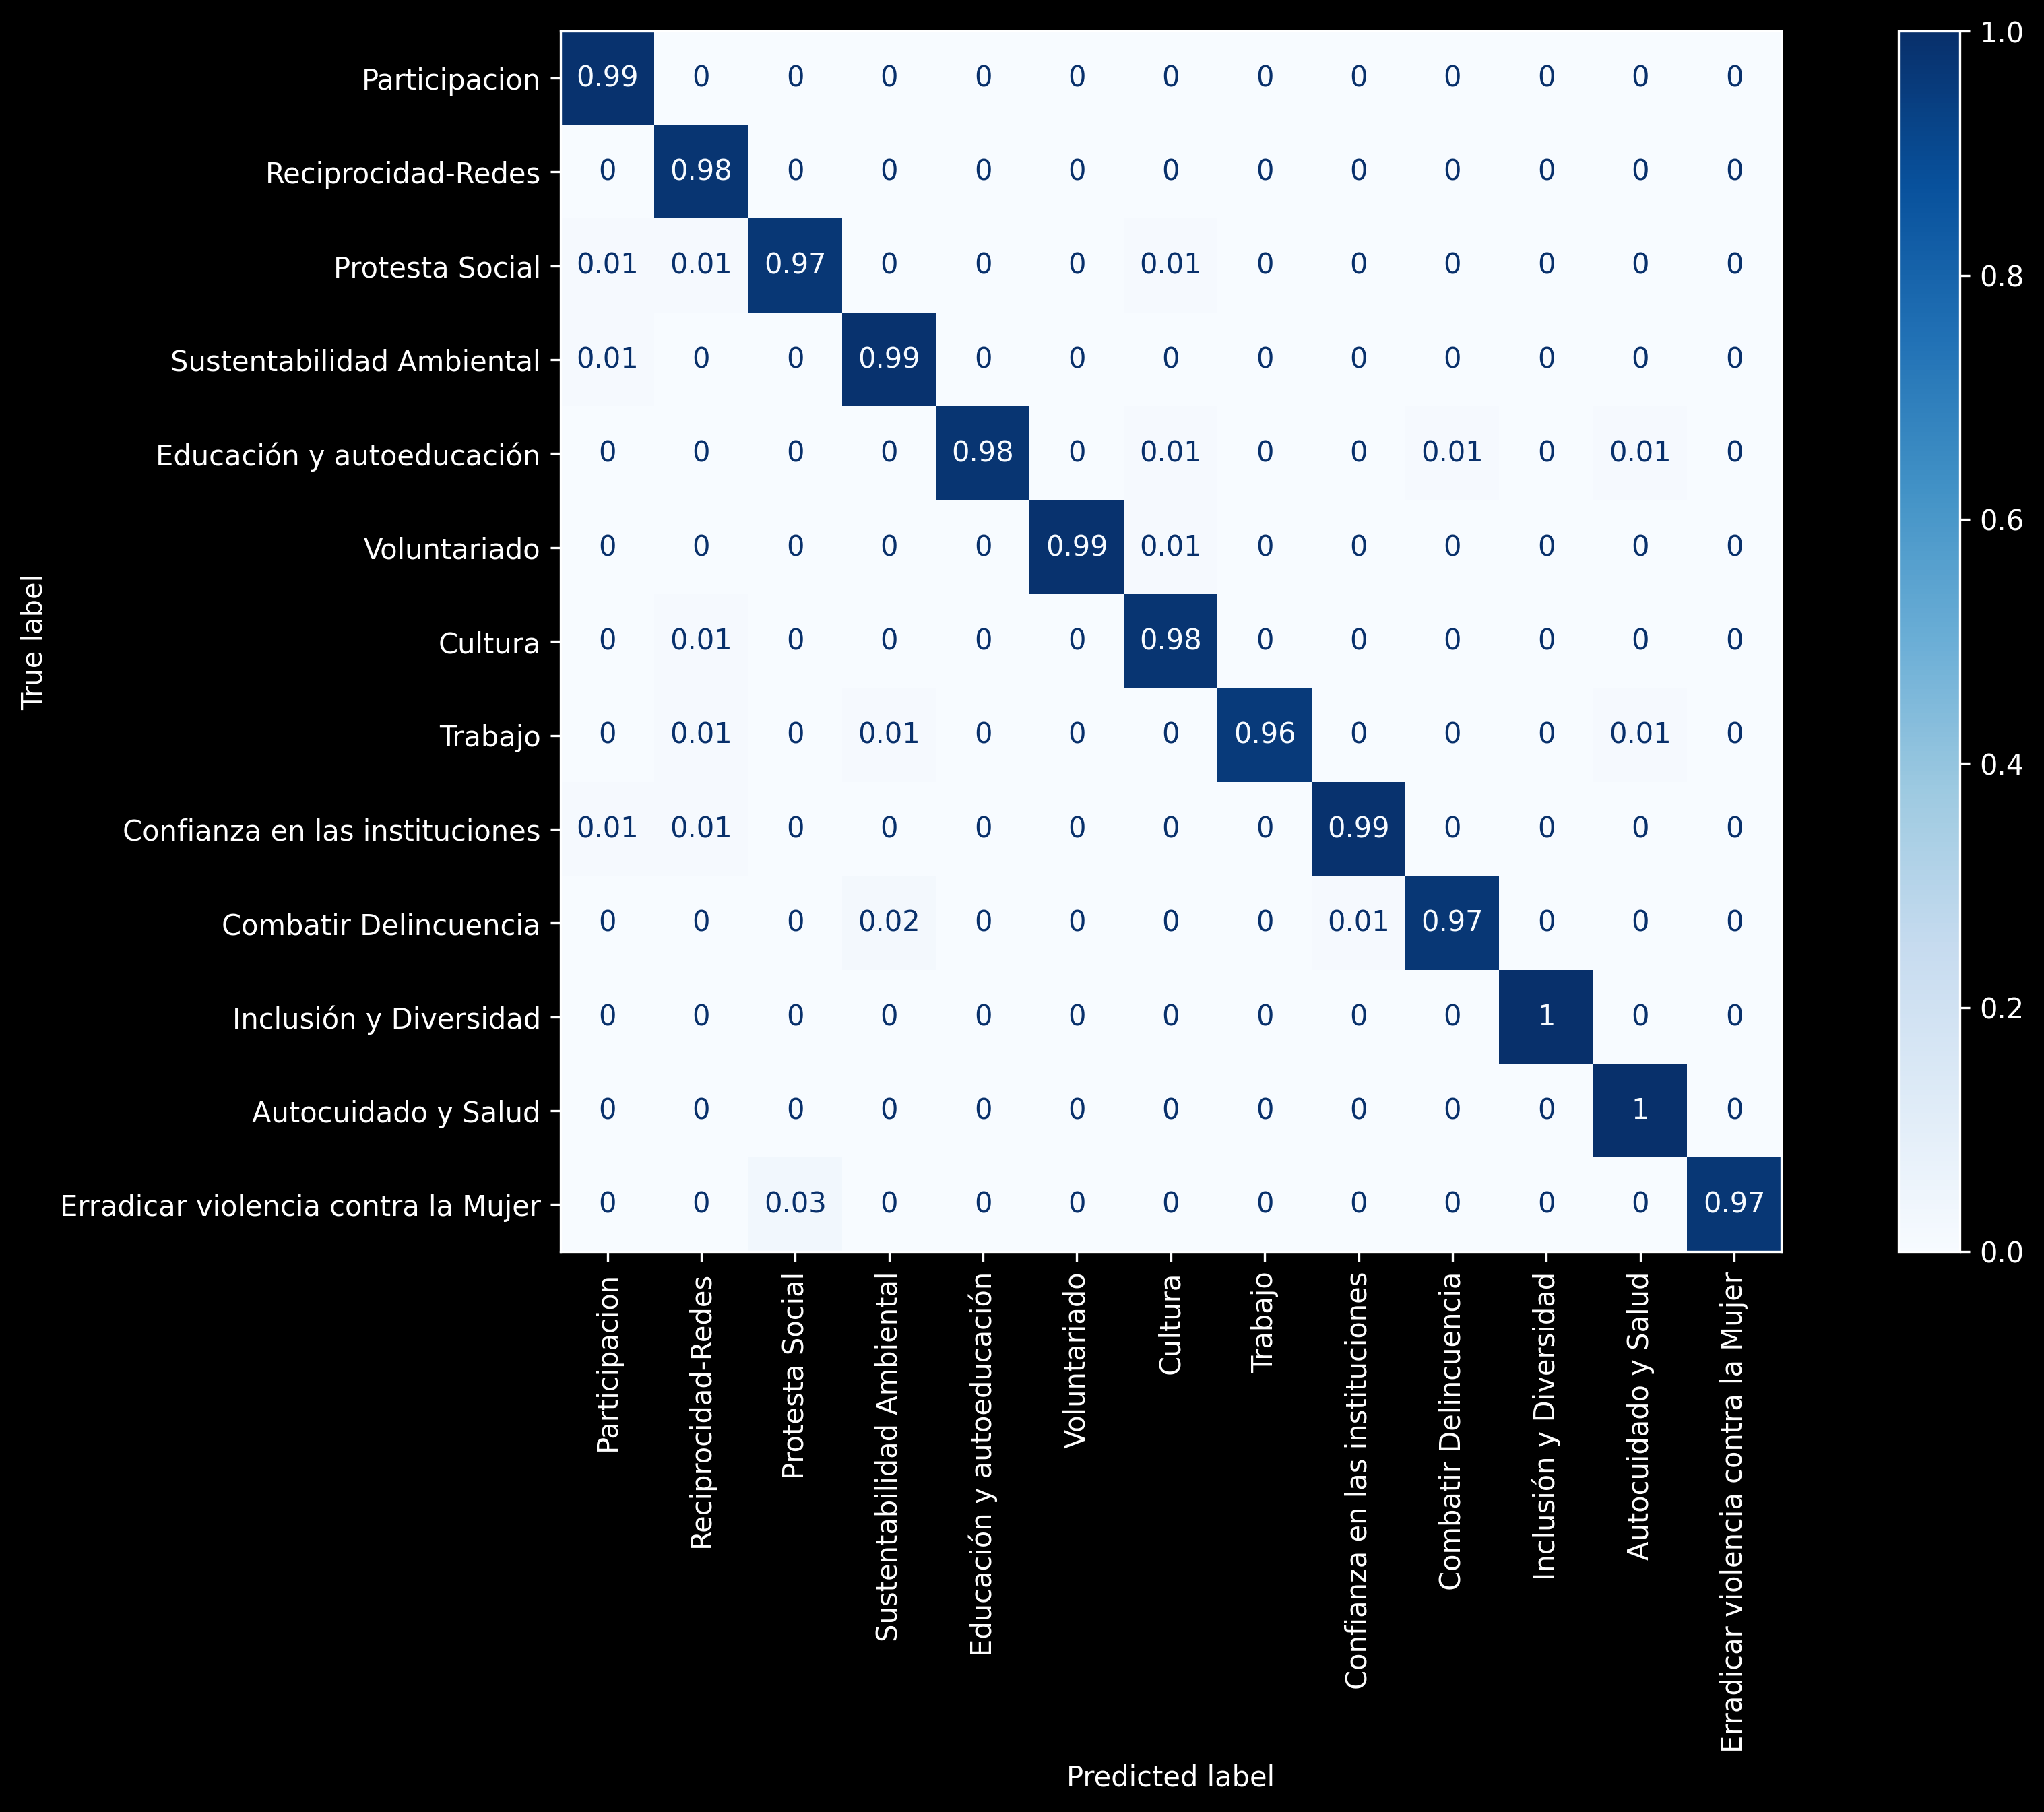

In [27]:
cm = confusion_matrix(y_true, y_pred, normalize='true')
cm = np.round(cm, 2)
fig, ax = plt.subplots(1,1, dpi=300, figsize=(15, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)


# # NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)

plt.show()

In [44]:
alldata_path = './data/records/all_contrib'
test_batches, n_cls = load_records(os.path.join(alldata_path, 'train'),
                                   batch_size=1000,
                                   return_cls=True,
                                   get_all=True)

In [71]:
labels_cls = {0:'Participacion', 
              1:'Reciprocidad-Redes',
              2:'Protesta Social', 
              3:'Sustentabilidad Ambiental', 
              4:'Educación y autoeducación', 
              5:'Voluntariado', 
              6:'Cultura', 
              7:'Trabajo', 
              8:'Confianza en las instituciones', 
              9:'Combatir Delincuencia',
              10:'Inclusión y Diversidad',
              11:'Autocuidado y Salud', 
              12:'Erradicar violencia contra la Mujer', 
              }

In [46]:
y_pred , _, texts = model.predict(test_batches)

In [34]:
import pandas as pd 

In [83]:
data = pd.read_csv('./data/contributions_v2.csv')

In [87]:
data['resume'] = data['resume'].replace({'NR': 'Trabajo'})

unique_classes = list(data['resume'].unique())
unique_classes

['Participacion',
 'Reciprocidad-Redes',
 'Protesta Social',
 'Sustentabilidad Ambiental',
 'Educación y autoeducación',
 'Voluntariado',
 'Trabajo',
 'Cultura',
 'Confianza en las instituciones',
 'Combatir Delincuencia',
 'Inclusión y Diversidad',
 'Autocuidado y Salud',
 'Erradicar violencia contra la Mujer']

In [ ]:
new_labels = ['Reciprocidad-Redes',
              'Educación y autoeducación',
              'Protesta Social',
              'Inclusión y Diversidad',
              'Participacion',
              'Sustentabilidad Ambiental',

              'Voluntariado',
              'Trabajo',
 'Cultura',
 'Confianza en las instituciones',
 'Combatir Delincuencia',
 
 'Autocuidado y Salud',
 'Erradicar violencia contra la Mujer']

In [124]:
c = 8
lab_pred_v = [unique_classes[y] for y in y_pred[y_pred==c]]
texts_v = texts[y_pred==c]

count = 0
for l1, l2 in zip(lab_pred_v, texts_v):
    print(l1,'\t', str(l2[0]))
    count+=1
    if count == 20: break

Confianza en las instituciones 	 b'informarme por redes cre\xc3\xadbles'
Confianza en las instituciones 	 b'reduciendo el consumo de carne.'
Confianza en las instituciones 	 b'preocuparse por el bien de los dem\xc3\xa1s, no s\xc3\xb3lo de nuestra'
Confianza en las instituciones 	 b'Inculcar a los jovenes el cuidado por el patrimonio las costumbres'
Confianza en las instituciones 	 b'Hablar en publico y reclamar por los problemas que existen en el altiplano que esta trazado y abandonado'
Confianza en las instituciones 	 b'ayudar\xc3\xada a la gente que es m\xc3\xa1s pobre que yo'
Confianza en las instituciones 	 b'apoyar las buenas ideas que nazcan de este periodo'
Confianza en las instituciones 	 b'tomar conciencia, ser menos individualista. m\xc3\xa1s emp\xc3\xa1tico.'
Confianza en las instituciones 	 b'proporcionar - e informaci\xc3\xb3n a mi familia para estar informado para aportar con base'
Confianza en las instituciones 	 b'tiempo con la familia / el valor de ella'
Confianza en l

In [ ]:
data['']

Participacion 	 b'ayudar a mi vecino.'
Participacion 	 b'solidaridad, colaborar en las necesidades de terceros, materializar\xc3\xada en terreno.'
Participacion 	 b'Ser mas tolerante, respetuosa , solidaria , emp\xc3\xa1tica'
Participacion 	 b'siendo emp\xc3\xa1tica entre las personas.'
Participacion 	 b'mayor empat\xc3\xada entre las personas.'
Participacion 	 b'si pudiera ayudarla a todas personas'
Participacion 	 b'ser m\xc3\xa1s solidario y ayudar al resto de las personas'
Participacion 	 b'ser m\xc3\xa1s empatados con todas las personas'
Participacion 	 b'valores vienen de casa'
Participacion 	 b'Empat\xc3\xada con el resto de las personas .'
Participacion 	 b'empatizar con el resto de las personas'
Participacion 	 b'mantener una actitud positiva / contagiar alegr\xc3\xada / ser emp\xc3\xa1tico'
Participacion 	 b'apoyar club adulto mayor, como ayuda a la secretaria.'
Participacion 	 b'apoyo a la tercera edad'
Participacion 	 b'apoyar al vecino que pueda tener complicaciones.'
Part

Participacion 	 b'hacer valer nuestro derecho de elegir a quienes nos representan yendo a votar a las elecciones'
Participacion 	 b'empata '
Participacion 	 b'asistir a votar para tener un chile representativo'
Participacion 	 b'asistir a votar obligatoriamente para manifestar la opini\xc3\xb3n como compatriota '
Participacion 	 b'participar en las elecciones.'
Participacion 	 b'priorizar en la integracion social para la ayuda a la comunidad'
Participacion 	 b'trabajar arduamente en cualquier gobierno que exista'
Participacion 	 b'ir a votar por la nueva constituci\xc3\xb3n '
Participacion 	 b'participaci\xc3\xb3n activa en temas sociales que involucren a la comunidad.'
Participacion 	 b'participaci\xc3\xb3n activa en votaci\xc3\xb3n por la nueva constituci\xc3\xb3n  '
Participacion 	 b'participaci\xc3\xb3n en mejoras de la vida de adultos mayores'
Participacion 	 b'participar en apoyar mas a la comunidad '
Participacion 	 b'traspasar lo que saben, incentivar a los mas jovenes a ir a v

Participacion 	 b'no aprovecharse del sistema las personas oportunistas'
Participacion 	 b'puedo  aprender a difundir todo lo que ocurre en mi pa\xc3\xads '
Participacion 	 b'puedo aprender y difundir todo lo que ocurre en mi pa\xc3\xads'
Participacion 	 b'asegurar la calidad de vida de todos los ciudadanos'
Participacion 	 b'actuar ante un maltrato o abuso a la ciudadan\xc3\xada'
Participacion 	 b'realizar labor social'
Participacion 	 b'interiorizarse sobre la constituci\xc3\xb3n actual para poder opinar sobre la nueva.'
Participacion 	 b'no a la reelecci\xc3\xb3n de la clase politica'
Participacion 	 b'hago trabajos a pedido de la ciudadania'
Participacion 	 b'participaci\xc3\xb3n social y ciudadana'
Participacion 	 b'participaci\xc3\xb3n social y ciudadana capacitando a vecino@s'
Participacion 	 b'generar mas trabajo'
Participacion 	 b'votar, estar informado, tener una actitud positiva '
Participacion 	 b'los valores de la patria.estos diciendo en abril dare mi opinion'
Participaci

Participacion 	 b'Tratando de compartir con todos, escuchando, ser solidario, compromiso'
Participacion 	 b'participar de la politica, todos estamos incorioson la problematica pais '
Participacion 	 b'responsabilidad en el trabajo'
Participacion 	 b'pymes: dar trabajo a las personas'
Participacion 	 b'aportar con la sabidur\xc3\xada a la comunidad'
Participacion 	 b'participaci\xc3\xb3n social'
Participacion 	 b'responsabilidad compartido desde las acciones concretas como .......hasta el apoyo estatal'
Participacion 	 b'no a la reelecci\xc3\xb3n de los mismos por m\xc3\xa1s de un periodo.'
Participacion 	 b'participar en organizaciones solidarias'
Participacion 	 b'Participar en las organizaciones y apoyar'
Participacion 	 b'mejorar relaci\xc3\xb3n con los vecinos'
Participacion 	 b'hablar con la juventud por la parte civica'
Participacion 	 b'Cambio definitivo a constituci\xc3\xb3n'
Participacion 	 b'incentivar participaci\xc3\xb3n a plebiscitos '
Participacion 	 b'contribuyo al biene

Participacion 	 b'participar en las votaciones de mi comuna. '
Participacion 	 b'que ayude a las personas m\xc3\xa1s vulnerables'
Participacion 	 b'Ser una persona informada para exigir, solucionar y opinar. '
Participacion 	 b'votar (hacer uso de ese derecho) para exigir con derecho.'
Participacion 	 b'asamblea constitucional y libre'
Participacion 	 b'ser consecuente con nuestra reflexi\xc3\xb3n de manera consiente en los equipos de trabajo'
Participacion 	 b'empat\xc3\xada con las personas debido a la realidad distinta entre las personas '
Participacion 	 b'participacion activa en la charla'
Participacion 	 b'disposici\xc3\xb3n a dialogar.'
Participacion 	 b'como representante social, '
Participacion 	 b'Fomentar espacios de participaci\xc3\xb3n y continuar las gestiones y acciones que han realizado como dirigentes sociales. '
Participacion 	 b'participar en cabildos (responsabilidad civica)'
Participacion 	 b'4 cooperando en jjv. y grupos funcionales '
Participacion 	 b'reciclar y 

Participacion 	 b'participar m\xc3\xa1s'
Participacion 	 b'replicar di\xc3\xa1logos ciudadanos como funcionaria de sistema p\xc3\xbablico con el fin de conocer impresiones de los usuarios con los que trabajo'
Participacion 	 b'votar en el plebiscito.'
Participacion 	 b'asociaci\xc3\xb3n para ayudar a los adultos mayores para pedir horas'
Participacion 	 b'trabajar en comunidad'
Participacion 	 b'participaci\xc3\xb3n en junta vecinal.'
Participacion 	 b'unir a las comunidades ind\xc3\xadgenas.'
Participacion 	 b'participar en cabildos.'
Participacion 	 b'tener una buena convivencia con la comunidad'
Participacion 	 b'participaci\xc3\xb3n ciudadana'
Participacion 	 b'realizamos actividades de venta en donde hay ferias para que las personas compren.'
Participacion 	 b'participar activamente de los encuentros ciudadanos. desde mi nivel como funcionaria p\xc3\xbablica entregando orientaci\xc3\xb3n, atenci\xc3\xb3n e informaci\xc3\xb3n oportuna a las personas que lo requieran. como madre, ed

Participacion 	 b'participar y votar informado'
Participacion 	 b'participar de todas las instancias que permitan aprendizaje y entrega de conocimientos'
Participacion 	 b'participaci\xc3\xb3n activa e informada (educaci\xc3\xb3n)'
Participacion 	 b'participaci\xc3\xb3n en forma responsable. ejercicio profesional con sentido social'
Participacion 	 b'ir a votar'
Participacion 	 b'participar en asambleas'
Participacion 	 b'votando'
Participacion 	 b'compromiso de difundir la informaci\xc3\xb3n respecto a beneficios con el resto de la comunidad'
Participacion 	 b'participar en club de adulto mayor.'
Participacion 	 b'participaci\xc3\xb3n social.'
Participacion 	 b'estudiar para servir a la comunidad (profesional)'
Participacion 	 b'comunidad ind\xc3\xadgena (todo el grupo pertenece a una comunidad ind\xc3\xadgena)'
Participacion 	 b'Votar'
Participacion 	 b'votar'
Participacion 	 b'participaci\xc3\xb3n ciudadana'
Participacion 	 b'participaci\xc3\xb3n ciudadana activa, en el sufragio y c

Participacion 	 b'participar y apoderarse'
Participacion 	 b'participar'
Participacion 	 b'transmitir valores de responsabilidad y participacion y discutirlo en familia'
Participacion 	 b'ayudar a la comunidad'
Participacion 	 b'Participar en votaciones aunque no sea obligatorio'
Participacion 	 b'fomentar en debate sano y ambientado motivar con el ejemplo el deporte y la nutrici\xc3\xb3n . utilizar la carrera con una arista con rol social, aportando conocimientos a la comunidad'
Participacion 	 b'ayudar a la comunidad sin necesidad de algo a cambio  y fomentar la carrera para la comunidad generar conciencia en la utilizaci\xc3\xb3n de los recursos naturales'
Participacion 	 b'participando en grupos religiosos y vigilando el cuidado de la comunidad'
Participacion 	 b'la participaci\xc3\xb3n mediante las elecciones, voto obligatorio.'
Participacion 	 b'participar en los di\xc3\xa1logos ciudadanos.'
Participacion 	 b'tener un rol mas activo en la participaci\xc3\xb3n dentro y fuera del t

Participacion 	 b'el derecho del pueblo a expresarse en plebiscito cc/cambio de constituci\xc3\xb3n y el congreso solo implementa las ediciones'
Participacion 	 b'a partir de cierta cantidad de plata, de resuelva a peticiones a traves de consulta ciudadana o plebiscito'
Participacion 	 b'participaci\xc3\xb3n  social'
Participacion 	 b'. aumentar mi participacion vecinal'
Participacion 	 b'participar en los di\xc3\xa1logos y consultas ciudades.'
Participacion 	 b'asistiendo a votar'
Participacion 	 b'empat\xc3\xada con la comunidad'
Participacion 	 b'participaci\xc3\xb3n (votar, asistir a reuniones)'
Participacion 	 b'solidaridad con la comunidad'
Participacion 	 b'participaci\xc3\xb3n de las juntas de vecinos'
Participacion 	 b'participaci\xc3\xb3n ciudadana obligatoria en elecciones'
Participacion 	 b'participar en reuniones (junta de vecinos)'
Participacion 	 b'organizarlos ma en las comunidad'
Participacion 	 b'participar activamente de los procesos electorales'
Participacion 	 b'vo

Participacion 	 b'votar'
Participacion 	 b'votar'
Participacion 	 b'\xe2\x80\xa2 hacer comunidad. compartir con las personas que nos rodean y portales y apoyarlos en lo que podamos.'
Participacion 	 b'\xe2\x80\xa2 participaci\xc3\xb3n activa.'
Participacion 	 b'votar, elegir bien a las autoridades'
Participacion 	 b'hacer comunidad, ser amables y predicar el compa\xc3\xb1erismo'
Participacion 	 b'mayor participaci\xc3\xb3n en asambleas territoriales o actividades comunitarias'
Participacion 	 b'participaci\xc3\xb3n'
Participacion 	 b'participacion'
Participacion 	 b'mi rol ciudadano ( votar, derechos, deberes) participaci\xc3\xb3n , representaci\xc3\xb3n'
Participacion 	 b'Participar de los cabildos abiertos'
Participacion 	 b'Participar en espacios que difundan valores universales'
Participacion 	 b'participaci\xc3\xb3n ciudadana'
Participacion 	 b'cabildo abierto'
Participacion 	 b'+ir a votar (ejercer derecho al voto)'
Participacion 	 b'fomentar la participacion ciudadana'
Participa

Participacion 	 b'manifestarse de alguna manera frente al cambio de constituci\xc3\xb3n'
Participacion 	 b'continuar con el control social'
Participacion 	 b'Informarme mas sobre realidad social'
Participacion 	 b'Trabajar por la reinserci\xc3\xb3n social'
Participacion 	 b'asistir a las manifestaciones'
Participacion 	 b'prepararse mucho mas como dirigente social, capacitar, no confundir a la gente.'
Participacion 	 b'marchando y manifestando el descontento.'
Participacion 	 b'aporte de politica social'
Participacion 	 b'apoyar el movimiento social.'
Participacion 	 b'manifestarse'
Participacion 	 b'apoyo al dirigente social'
Participacion 	 b'solidariza y empatizar con la realidad social.'
Participacion 	 b'ir a manifestarse pac\xc3\xadficamente'
Participacion 	 b'-todo lo anterior, precisa de la suma de contribuciones personales en torno a un mayor compromiso social.'
Participacion 	 b'mas labor social'
Participacion 	 b'manifestaron cuando sea necesario'
Participacion 	 b'responsab